## **数据处理**
此时我还基本什么都不会，只知道大概把给出的信息筛一筛

In [1]:
# !ls /home/aistudio/data
# !ls /home/aistudio/data/data1917

# !unzip  -q -o /home/aistudio/data/data1917/train_new.zip
# !unzip  -q -o /home/aistudio/data/data1917/test_new.zip

首先定位实验全部数据
1.  训练集 train_new.zip 位于 /home/aistudio/data/data1917/train_new.zip
2.  测试集 test_new.zip  位于 /home/aistudio/data/data1917/test_new.zip

上面的命令就是将其解压，下面看一下data1917这个目录

In [2]:
# !ls /home/aistudio/data/data1917 -a

In [3]:
!ls /home/aistudio/test -l | grep '^-' | wc -l

1000


上面那个目录中只有train.json,实际其他的内容被解压到了用户主目录下 ~/test和~/train两个文件夹  
我们先来看看train.json里面的内容

In [4]:
# !head -n 20 /home/aistudio/data/data1917/train.json
# 从下面结果已经可以看出它的内容是什么意思了,实际可以在左侧数据集那儿直接看到
# 给出了每张图片的名称,stage1/train是多余的前缀,后面根了id和num这些,这个实验受性能影响要求使用num<20,后面根num个位置[x,y,w,h]就是人的区域

In [5]:
# 挑张图片看一下
import os
from PIL import Image, ImageDraw
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# jpg = mpimg.imread('./train/61a4091324d1983534ca23b6f007f841.jpg')  # ipynb 文件就处于 ~/目录  ./tr....即 ~/train/...
# plt.imshow(jpg)

### **正式数据处理**

In [6]:
# 经过学习前面的加压命令用不上了,直接使用zipfile库解压
# 后续使用中删除了zipfile,程序主体用不上
# import zipfile
import paddle
import paddle.fluid as fluid
import time
import paddle.fluid.dygraph as dygraph
import numpy as np
import random

In [7]:
# 补充
import cv2
import sys
import h5py
from paddle.utils.plot import Ploter

In [8]:
# 记录程序正式开始时间
start_time = time.time()
# 处理json数据
os.getcwd()
os.listdir()
f = open('/home/aistudio/data/data1917/train.json', encoding='utf-8')
train_tmp = json.load(f)
# 依次输出这个转换来的json字典的信息,直至定位至每个图片
# 首先发现 json 有四个key-value对,我们所需的 'annotations ': 的value是个字典列表,每个字典元素对应一个图片
print(train_tmp['annotations'][0].keys())
print(train_tmp['annotations'][0]['name'])
print(train_tmp['annotations'][0]['id'])
print(train_tmp['annotations'][0]['num'])
print(train_tmp['annotations'][0]['ignore_region'])
print(train_tmp['annotations'][0]['type'])

dict_keys(['name', 'id', 'num', 'ignore_region', 'type', 'annotation'])
stage1/train/61a4091324d1983534ca23b6f007f841.jpg
625
28
[]
bbox


{'name': 'stage1/train/83f23ac658f0bc9326fcd8a7d6996476.jpg', 'id': 628, 'num': 7, 'ignore_region': [], 'type': 'dot', 'annotation': [{'y': 257, 'x': 43}, {'y': 206, 'x': 98}, {'y': 247, 'x': 333}, {'y': 236, 'x': 102}, {'y': 1032, 'x': 247}, {'y': 919, 'x': 660}, {'y': 1057, 'x': 1414}]}
1190


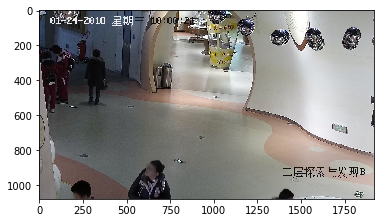

In [9]:
# 筛选数据
# limit_num 根据图片中的人数 筛选规模
limit_num = 20
train_res = []
count = 0
for png in train_tmp['annotations']:
    if png['num'] <= limit_num:
        train_res.append(png)
        count += 1
print(train_res[2])
print(count)
# 在此过程中发现有些图片给出的类型是dot,只有下,y没有w,h. 不是bbox类型
jpg2 = mpimg.imread('./train/83f23ac658f0bc9326fcd8a7d6996476.jpg')  # ipynb 文件就处于 ~/目录  ./tr....即 ~/train/...
plt.imshow(jpg2)

{'name': 'stage1/train/45e6e2c0db47035668fc24b98c0af667.jpg', 'id': 641, 'num': 14, 'ignore_region': [], 'type': 'bbox', 'annotation': [{'y': 100, 'x': 1387, 'w': 78, 'h': 239}, {'y': 208, 'x': 1423, 'w': 43, 'h': 144}, {'y': 325, 'x': 1633, 'w': 171, 'h': 393}, {'y': 1, 'x': 835, 'w': 58, 'h': 141}, {'y': 1, 'x': 730, 'w': 48, 'h': 145}, {'y': 530, 'x': 119, 'w': 52, 'h': 168}, {'y': 161, 'x': 1200, 'w': 105, 'h': 293}, {'y': 233, 'x': 1415, 'w': 91, 'h': 307}, {'y': 367, 'x': 1348, 'w': 156, 'h': 454}, {'y': 306, 'x': 1223, 'w': 157, 'h': 514}, {'y': 324, 'x': 668, 'w': 39, 'h': 105}, {'y': 0, 'x': 1192, 'w': 47, 'h': 75}, {'y': 0, 'x': 653, 'w': 47, 'h': 98}, {'y': 0, 'x': 1363, 'w': 59, 'h': 97}]}


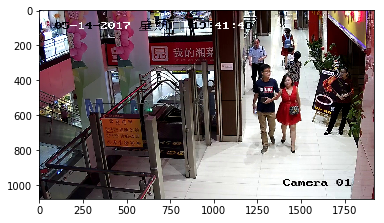

In [10]:
## 暂时重新筛选一下数据, 只选取bbox类型的
# limit_num 根据图片中的人数 筛选规模
limit_num = 20
train_res = []
for png in train_tmp['annotations']:
    if png['num'] <= limit_num and png['type'] == 'bbox':
        train_res.append(png)
print(train_res[2])
# 在此过程中发现有些图片给出的类型是dot,只有下,y没有w,h. 不是bbox类型
jpg2 = mpimg.imread('.'+train_res[2]['name'].lstrip('stage1'))  # ipynb 文件就处于 ~/目录  ./tr....即 ~/train/...

plt.imshow(jpg2)

- 到了这一步,大概已经可以通过json筛选出所有合乎要求的图片的相关信息了  
  关于dot类型的图片放到后边扩展处理

截至到目前，我们还差的任务大概有  
- **关于图片两种类型dot 和 bbox 的处理**,猜测应该是搞成一种类型 
  估计不会是放弃某种类型,要不然数据浪费?
- **图片应该有进一步处理**比如灰度化什么的
- **数据的生成**,用paddle框架的话,之前学习的两个项目都用到了paddle.batch读取训练数据
  但是没有什么minist.train(),所以我们应该也是写个类似的函数,用来生成数据
  
到这一步已经进入瓶颈,先跳过,直接转至下面**数据准备**部分

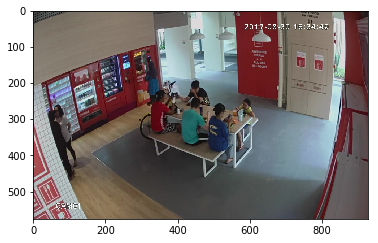

In [11]:
# 挨个浏览json 逮到了一张 忽略区 不为空的图片看一下什么样
jpg_reg = mpimg.imread('./train/c8ae86a2fd1e02b79ccfd5652625875c.jpg') 
plt.imshow(jpg_reg)

In [12]:
# 直接手动看json找了两个 有 忽略区的
# 结果都是dot类型的
# 查一下是不是所有的都是这样
for png in train_tmp['annotations']:
    # if png['ignore_region'] and len(png['ignore_region'][0][0]) <= 2:
    if png['ignore_region'] and len(png['ignore_region'][0][0]) > 2:
        print(png['ignore_region'])
# 两个if的结果证明json忽略区都是 dot类型的

id =  661
928 576
15


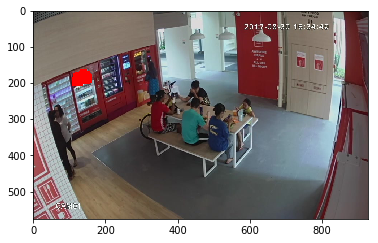

In [13]:
# 已知忽略区给的同样是一堆dot,看一下这些dot画出来是什么样的
im = Image.open('./train/c8ae86a2fd1e02b79ccfd5652625875c.jpg')
for j in range(len(train_tmp['annotations'])):
    # print(train_tmp['annotations'][j]['name'].lstrip('stage1/'))
    if train_tmp['annotations'][j]['name'].lstrip('stage1') == '/train/c8ae86a2fd1e02b79ccfd5652625875c.jpg':
        print('id = ',train_tmp['annotations'][j]['id'])   #图片id
        ann = train_tmp['annotations'][j]['ignore_region'][0]
#可视化图片所有标注信息
width = im.size[0]    #获取宽度
height = im.size[1]   #获取长度
print(width,height)
print(len(ann))
draw = ImageDraw.Draw(im)
for a in ann:        #遍历所有标注
    px, py = a['x'], a['y']
    for x in range(width):
        for y in range(height):             
            if(x > (px-10) and x < (px+10) and y > py-10 and y < (py+10)):  #取坐标范围正负10的像素        
                im.putpixel((x,y),(255,0,0))
    # draw.line((x-5, x+5, y+5, y-5), fill=10, width=200)
plt.imshow(im)
# 看了之后发现这个忽略区其实没必要看...也就是训练的时候排除用的

### **真正对图片进行处理**
- - -
初步考虑采用高斯滤波的方式经过归一化处理等  
最终转换成 点状的密度图  
这样一来关于bbox 和 dot这两种 我们就可以把bbox转变成dot  
处理起来更简单
- 下面的没有灰度化处理 imge shape应该为[3, 620, 480]

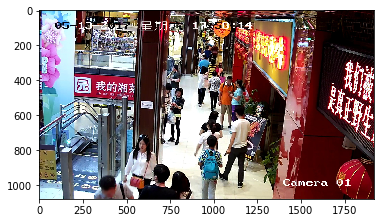

In [14]:
# josn处理
# 之前很多次用到json里的路径都要分割stage1,下面完全把它割掉
for i in range(len(train_tmp['annotations'])):
    train_tmp['annotations'][i]['name'] = train_tmp['annotations'][i]['name'].lstrip('stage1').lstrip('/') # 不能是stage1/ 不然直接把 train的t也割掉了
    # print(train_tmp['annotations'][i]['name'])
tes = Image.open(train_tmp['annotations'][10]['name'])
plt.imshow(tes)
# Error 发现不能打开 '/train/...' 考虑到前面的结论,此notebook在HOME下,所以要打开文件要么 ./train/..要么 train/...
# 二次更改 把/也给裁掉
# ok

In [15]:
# ims = train_tmp['annotations'][10]['name']
# plt.imshow(Image.open(ims))
# gt_file = h5py.File(ims.replace('.jpg','.h5').replace('images','ground-truth'),'r')
# groundtruth = np.asarray(gt_file['density'])
# plt.imshow(groundtruth,cmap=CM.jet)

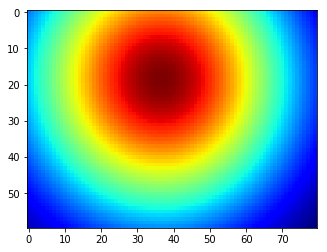

In [16]:
from scipy.ndimage.filters import gaussian_filter 
import scipy
from matplotlib import cm as CM
# 高斯滤波
# gt 是 每个图片标注中的 人物位置 列表
# gt 最终是n*2的即shape为(n ,2) 因为bbox转成了dot
def gaussian_filter_density(gt):
    
    # 初始化密度图
    density = np.zeros(gt.shape, dtype=np.float32)
    
    # 获取gt中不为0的元素的个数
    gt_count = np.count_nonzero(gt)
    
    # 如果gt全为0，就返回全0的密度图
    if gt_count == 0:
        return density
    
    pts = np.array(list(zip(np.nonzero(gt)[1].ravel(), np.nonzero(gt)[0].ravel())))
    
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            # sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
            sigma = 25
        else:
            sigma = np.average(np.array(gt.shape))/2./2. 
        
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')

    return density


# 图片resize 成 640*480 
# 将bbox变为 dot
# 参数img为图片 ann为对应的人物位置
# 输出是大小格式化的img 和 bbox转 dot 且经过原shape->(640, 80)->(80, 60)二次压缩 的ann即gt
def picture_opt(img, ann):
    size_x, size_y = img.size
    # train_img_size = (640,480)
    img = img.resize((640, 480), Image.ANTIALIAS)
    # img = img.resize((640, 480)), Image.ANTIALIAS)
    img = np.array(img)                  
    img = img / 255.0
    # print(ann)
    # print(len(ann))
    gt = []
    for b_l in range(len(ann)):
        # 假设人体是使用方框标注的，通过求均值的方法将框变为点
        if 'w' in ann[b_l].keys(): 
            x = (ann[b_l]['x']+(ann[b_l]['x']+ann[b_l]['w']))/2
            y = ann[b_l]['y']+20
            x = (x*640/size_x)/8
            y = (y*480/size_y)/8
            gt.append((x,y))   
        else:
            x = ann[b_l]['x']
            y = ann[b_l]['y']
            x = (x*640/size_x)/8
            y = (y*480/size_y)/8
            gt.append((x,y)) 

    # for a in ann:
    #     # 假设人体是使用方框标注的，通过求均值的方法将框变为点
    #     if 'w' in a.keys(): 
    #         x = (a['x']+(a['x']+a['w']))/2
    #         y = a['y']+20
    #         x = (x*640/size_x)/8
    #         y = (y*480/size_y)/8
    #         gt.append((x,y))   
    #     else:
    #         x, y = a['x'] = a['y']
    #         x = (x*640/size_x)/8
    #         y = (y*480/size_y)/8
    #         gt.append((x,y)) 

    return img, gt

def ground(img,gt):
    imgs = img
    x = imgs.shape[0]/8
    y = imgs.shape[1]/8
    k = np.zeros((int(x),int(y)))

    for i in range(0,len(gt)):
        if int(gt[i][1]) < int(x) and int(gt[i][0]) < int(y):
            k[int(gt[i][1]),int(gt[i][0])]=1

    k = gaussian_filter_density(k)
    return k

# 用之前的tes 图片试一下train_tmp['annotations'][10]['name']
ann = train_tmp['annotations'][10]['annotation']
im1, gt = picture_opt(tes, ann)
k = ground(im1, gt)
# print(k)
plt.imshow(k,cmap=CM.jet)
# 如下是个规模80*60的图

[[955, 119], [931, 150], [931, 122], [911, 123], [805, 121], [446, 119], [262, 115], [438, 596], [753, 130], [980, 183], [913, 224], [904, 253], [965, 277], [1032, 350], [966, 346], [907, 317], [739, 309], [1026, 372], [1078, 389], [683, 420], [738, 443], [918, 574], [892, 627], [1029, 543], [911, 717], [483, 707]]
(1080, 1920)
(1080, 1920)
Sum =  25.999992


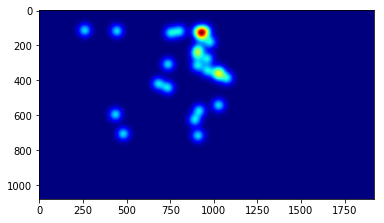

In [17]:
gt2 = []
for a in range(len(ann)):
    gt2.append([ann[a]['x'],ann[a]['y']])
print(gt2)
gt2 = np.array(gt2)

# Gauss密度图
tes2 = plt.imread(train_tmp['annotations'][10]['name'])


k2 = np.zeros((tes2.shape[0],tes2.shape[1]))

for i in range(0,len(gt)):
    if int(gt2[i][1]) < tes2.shape[0] and int(gt2[i][0]) < tes2.shape[1]:
        k2[int(gt2[i][1]),int(gt2[i][0])]=1
    
    # generate density map
k2 = gaussian_filter_density(k2)

print(k2.shape)
groundtruth = np.asarray(k2)
# groundtruth = groundtruth.resize((80,60))
print(groundtruth.shape)
plt.imshow(groundtruth,cmap=CM.jet)
print("Sum = " ,np.sum(groundtruth))

In [18]:
# # 有几张图片人数过多的给他顾虑掉
# ign = Image.open('train/8538edb45aaf7df78336aa5b49001be6.jpg')
# plt.imshow(ign)
# ign2 = Image.open('train/377df0a7a9abc44e840e938521df3b54.jpg')
# plt.imshow(ign2)

**上面三个函数的关系**: Gauss滤波纯粹根据gt=[[x,y],...]生成一个密度图  
picture_opt 将图片全部变成640\*480的,同时将ann(也就是任务位置从bbox转成dot再压缩至80\*60当然了,不对图图片进行二次压缩)  
group根据这个640\*480的图片以及(此时已经是)80\*60的gt生成np数组再进行高斯滤波  
所以三个函数执行顺序应该是  
`picture_opt`->`ground(在内部执行Gauss)`
### 关于数据生成

In [19]:
def train_data():
    # # 先不考虑 筛选 人数<20 的图片
    # all_num = 2000
    # offset = 0.8
    # if typed == 'train':
    #     starts, ends = 0, (int)(all_num * offset)
    # else:
    #     starts, ends = (int)(all_num * offset), 2000
    def inner():
        for ig_index in range(1600):                                                 #遍历所有图片
            # if train_tmp['annotations'][ig_index]['num'] > 20: continue
            if len(train_tmp['annotations'][ig_index]['annotation']) == 2:continue
            if len(train_tmp['annotations'][ig_index]['annotation']) == 3:continue
            if train_tmp['annotations'][ig_index]['ignore_region']:                      #把忽略区域都用像素为0填上
                ig_list = []                                                           #存放忽略区1的数据
                ig_list1 = []                                                          #存放忽略区2的数据
                # print(train_tmp['annotations'][ig_index]['ignore_region'])
                if len(train_tmp['annotations'][ig_index]['ignore_region'])==1:           #因为每张图的忽略区域最多2个，这里是为1的情况
                    # print('ig1',ig_index)
                    ign_rge = train_tmp['annotations'][ig_index]['ignore_region'][0]       #取第一个忽略区的数据
                    for ig_len in range(len(ign_rge)):                                   #遍历忽略区坐标个数，组成多少变型
                        ig_list.append([ign_rge[ig_len]['x'],ign_rge[ig_len]['y']])       #取出每个坐标的x,y然后组成一个小列表放到ig_list
                    ig_cv_img = cv2.imread(train_tmp['annotations'][ig_index]['name'])      #用cv2读取一张图片
                    pts = np.array(ig_list,np.int32)                                      #把ig_list转成numpy.ndarray数据格式，为了填充需要
                    cv2.fillPoly(ig_cv_img,[pts],(0,0,0),cv2.LINE_AA)                     #使用cv2.fillPoly方法对有忽略区的图片用像素为0填充
                
                    ig_img = Image.fromarray(cv2.cvtColor(ig_cv_img,cv2.COLOR_BGR2RGB))   #cv2转PIL
                    
                    ann = train_tmp['annotations'][ig_index]['annotation']          #把所有标注的信息读取出来
                                                                  
                    ig_im,gt = picture_opt(ig_img,ann)
                    k = ground(ig_im,gt)
                   
                    groundtruth = np.asarray(k)
                    groundtruth = groundtruth.T.astype('float32')
                    ig_im = ig_im.transpose().astype('float32')
                    yield ig_im,groundtruth
                    
                if len(train_tmp['annotations'][ig_index]['ignore_region'])==2:           #有2个忽略区域
                    # print('ig2',ig_index)
                    ign_rge = train_tmp['annotations'][ig_index]['ignore_region'][0]
                    ign_rge1 = train_tmp['annotations'][ig_index]['ignore_region'][1]
                    for ig_len in range(len(ign_rge)):
                        ig_list.append([ign_rge[ig_len]['x'],ign_rge[ig_len]['y']])
                    for ig_len1 in range(len(ign_rge1)):
                        ig_list1.append([ign_rge1[ig_len1]['x'],ign_rge1[ig_len1]['y']])  
                    ig_cv_img2 = cv2.imread(train_tmp['annotations'][ig_index]['name'])
                    pts = np.array(ig_list,np.int32)
                    pts1 = np.array(ig_list1,np.int32)
                    cv2.fillPoly(ig_cv_img2,[pts],(0,0,0),cv2.LINE_AA)                
                    cv2.fillPoly(ig_cv_img2,[pts1],(0,0,0),cv2.LINE_AA)
                    
                    ig_img2 = Image.fromarray(cv2.cvtColor(ig_cv_img2,cv2.COLOR_BGR2RGB))   #cv2转PIL
                    
                    ann = train_tmp['annotations'][ig_index]['annotation']                    #把所有标注的信息读取出来
                                                                  
                    ig_im,gt = picture_opt(ig_img2,ann)
                    k = ground(ig_im,gt)
                    k = np.zeros((int(ig_im.shape[0]/8),int(ig_im.shape[1]/8)))
                    
                    groundtruth = np.asarray(k)
                    groundtruth = groundtruth.T.astype('float32')
                    ig_im = ig_im.transpose().astype('float32')
                    yield ig_im,groundtruth
                    
            else:
                # 没有忽略区的最好办,直接打开图片加载任务位置进行picture_opt--> ground-->得到密度图即可
                img = Image.open(train_tmp['annotations'][ig_index]['name'])
                ann = train_tmp['annotations'][ig_index]['annotation']          #把所有标注的信息读取出来
                
                im,gt = picture_opt(img,ann)
                k = ground(im,gt)
                
                groundtruth = np.asarray(k)
                groundtruth = groundtruth.T.astype('float32')
                im = im.transpose().astype('float32')
                yield im, groundtruth
    # inner 即 这个数据reader 返回的是 处理过的image图片和 高斯滤波后的 密度图[矩阵]
    return inner

**前面统计的人数<=20 的有 1190 张**

In [20]:
def test_data():
    # # 先不考虑 筛选 人数<20 的图片
    # all_num = 2000
    # offset = 0.8
    # if typed == 'train':
    #     starts, ends = 0, (int)(all_num * offset)
    # else:
    #     starts, ends = (int)(all_num * offset), 2000
    def inner():
        for ig_index in range(1600, 2000):                                                 #遍历所有图片
            # if train_tmp['annotations'][ig_index]['num'] > 20: continue
            if len(train_tmp['annotations'][ig_index]['annotation']) == 2:continue
            if len(train_tmp['annotations'][ig_index]['annotation']) == 3:continue
            if train_tmp['annotations'][ig_index]['ignore_region']:                      #把忽略区域都用像素为0填上
                ig_list = []                                                           #存放忽略区1的数据
                ig_list1 = []                                                          #存放忽略区2的数据
                # print(train_tmp['annotations'][ig_index]['ignore_region'])
                if len(train_tmp['annotations'][ig_index]['ignore_region'])==1:           #因为每张图的忽略区域最多2个，这里是为1的情况
                    # print('ig1',ig_index)
                    ign_rge = train_tmp['annotations'][ig_index]['ignore_region'][0]       #取第一个忽略区的数据
                    for ig_len in range(len(ign_rge)):                                   #遍历忽略区坐标个数，组成多少变型
                        ig_list.append([ign_rge[ig_len]['x'],ign_rge[ig_len]['y']])       #取出每个坐标的x,y然后组成一个小列表放到ig_list
                    ig_cv_img = cv2.imread(train_tmp['annotations'][ig_index]['name'])      #用cv2读取一张图片
                    pts = np.array(ig_list,np.int32)                                      #把ig_list转成numpy.ndarray数据格式，为了填充需要
                    cv2.fillPoly(ig_cv_img,[pts],(0,0,0),cv2.LINE_AA)                     #使用cv2.fillPoly方法对有忽略区的图片用像素为0填充
                
                    ig_img = Image.fromarray(cv2.cvtColor(ig_cv_img,cv2.COLOR_BGR2RGB))   #cv2转PIL
                    
                    ann = train_tmp['annotations'][ig_index]['annotation']          #把所有标注的信息读取出来
                                                                  
                    ig_im,gt = picture_opt(ig_img,ann)
                    k = ground(ig_im,gt)
                   
                    groundtruth = np.asarray(k)
                    groundtruth = groundtruth.T.astype('float32')
                    ig_im = ig_im.transpose().astype('float32')
                    yield ig_im,groundtruth
                    
                if len(train_tmp['annotations'][ig_index]['ignore_region'])==2:           #有2个忽略区域
                    # print('ig2',ig_index)
                    ign_rge = train_tmp['annotations'][ig_index]['ignore_region'][0]
                    ign_rge1 = train_tmp['annotations'][ig_index]['ignore_region'][1]
                    for ig_len in range(len(ign_rge)):
                        ig_list.append([ign_rge[ig_len]['x'],ign_rge[ig_len]['y']])
                    for ig_len1 in range(len(ign_rge1)):
                        ig_list1.append([ign_rge1[ig_len1]['x'],ign_rge1[ig_len1]['y']])  
                    ig_cv_img2 = cv2.imread(train_tmp['annotations'][ig_index]['name'])
                    pts = np.array(ig_list,np.int32)
                    pts1 = np.array(ig_list1,np.int32)
                    cv2.fillPoly(ig_cv_img2,[pts],(0,0,0),cv2.LINE_AA)                
                    cv2.fillPoly(ig_cv_img2,[pts1],(0,0,0),cv2.LINE_AA)
                    
                    ig_img2 = Image.fromarray(cv2.cvtColor(ig_cv_img2,cv2.COLOR_BGR2RGB))   #cv2转PIL
                    
                    ann = train_tmp['annotations'][ig_index]['annotation']                    #把所有标注的信息读取出来
                                                                  
                    ig_im,gt = picture_opt(ig_img2,ann)
                    k = ground(ig_im,gt)
                    k = np.zeros((int(ig_im.shape[0]/8),int(ig_im.shape[1]/8)))
                    
                    groundtruth = np.asarray(k)
                    groundtruth = groundtruth.T.astype('float32')
                    ig_im = ig_im.transpose().astype('float32')
                    yield ig_im,groundtruth
                    
            else:
                # 没有忽略区的最好办,直接打开图片加载任务位置进行picture_opt--> ground-->得到密度图即可
                img = Image.open(train_tmp['annotations'][ig_index]['name'])
                ann = train_tmp['annotations'][ig_index]['annotation']          #把所有标注的信息读取出来
                
                im,gt = picture_opt(img,ann)
                k = ground(im,gt)
                
                groundtruth = np.asarray(k)
                groundtruth = groundtruth.T.astype('float32')
                im = im.transpose().astype('float32')
                yield im, groundtruth
    # inner 即 这个数据reader 返回的是 处理过的image图片和 高斯滤波后的 密度图[矩阵]
    return inner

## **数据准备**

In [21]:
# 到这儿需要往前回去编写 train_gene() 和 test_gene()连个生成数据的函数
# 改名字了，还是用train_data()好
# 这是28*28用到的规模,应该是针对此设备交合适的了
# BUF_SIZE=512
# BATCH_SIZE=128
# 我们最终处理得到的图片应该是在280*280以上
# 类比规模得下降100倍左右
# 图片确定为640*480 规模依旧5 2
BUF_SIZE = 5
BATCH_SIZE = 2
train_reader = paddle.batch(
    paddle.reader.shuffle(train_data(), buf_size = BUF_SIZE) ,
    batch_size = BATCH_SIZE
)

test_reader = paddle.batch(
    paddle.reader.shuffle(test_data(), buf_size = BUF_SIZE) ,
    batch_size = BATCH_SIZE
)

#用于打印，查看train数据
# train_datas = train_data();
# sampledata = next(train_datas())
# print(sampledata)

## **网络配置**
- - -
~~先试试一般的方法,定义多层感知器,两个隐层~~

In [22]:
# 从后往前再到这儿发现这个 手写数字识别的模板根本不适合用在这儿
# # 多层感知器
# def mulitilayer_perceptron(input):
#     # 第一个全连接层
#     hidden1 = fluid.layers.fc(input=input, size=)


In [23]:
def cnn(ipt):
    print(ipt.shape)
    conv1 = fluid.layers.conv2d(input=ipt, 
                                num_filters=64, # filter数量，与通道数相同？
                                filter_size=3,  # 滤波器大小
                                padding=1, 
                                stride=1, 
                                name='conv1', 
                                act='relu')     # 激活类型
    print(conv1.shape)
    pool1 = fluid.layers.pool2d(input=conv1, 
                                pool_size=4,    # 池化层大小
                                pool_stride=4,  # 池化层步长
                                pool_type='max', 
                                name='pool1')
    print(pool1.shape)
    bn1 = fluid.layers.batch_norm(input=pool1, name='bn1')
    print(bn1.shape)
    conv2 = fluid.layers.conv2d(input=bn1, 
                                num_filters=128, 
                                filter_size=3, 
                                padding=1, 
                                stride=1, 
                                name='conv2', 
                                act='relu')
    print(conv2.shape)
    pool2 = fluid.layers.pool2d(input=conv2, 
                                pool_size=2, 
                                pool_stride=2,
                                pool_type='max', 
                                name='pool2')
    pool2 = fluid.layers.dropout(pool2, dropout_prob=0.25)
    print('dropout', pool2.shape)
    bn2 = fluid.layers.batch_norm(input=pool2, name='bn2')
    print('bn2', bn2.shape)

    # 反向传播
    conv3 = fluid.layers.conv2d(input=bn2, 
                                num_filters=128, 
                                filter_size=3, 
                                padding=2, 
                                stride=1,
                                dilation=2,
                                name='conv3', 
                                act='relu')
    print(conv3.shape)

    conv4 = fluid.layers.conv2d(input=conv3, 
                            num_filters=32, # filter数量，与通道数相同？
                            filter_size=3,  # 滤波器大小
                            padding=2, 
                            stride=1, 
                            dilation=2,
                            name='conv4', 
                            act='relu')     # 激活类型
    print(conv4.shape)

    conv5 = fluid.layers.conv2d(input=conv4, 
                            num_filters=1, # filter数量，与通道数相同？
                            filter_size=1,  # 滤波器大小
                            padding=0,
                            stride=1,
                            name='conv5', 
                            act=None)     # 激活类型  relu  和 None
    print(conv5.shape)
    
    # fc1 = fluid.layers.fc(input=conv5)
    # # fc1 = fluid.layers.fc(input=conv5, size=1, act='relu', name='fc1')
    # print('fc1',fc1.shape)
    # # fc2 = fluid.layers.fc(input=fc1, size=1, act='softmax', name='fc2')
    # # print(fc2.shape)
    return conv5

### 网络模型
~~看来一下那个啥网课里的目标检测~~  
~~先用用里面的SSD网络结构~~  
藏文里的cnn

In [25]:
# 定义数据层
# 图片是640*480 实际shape应该是 640， 480 在加上灰度 1 或者RGB 3
images = fluid.layers.data(name='images', shape=[3, 640, 480], dtype='float32')
# 标签 是最终的密度矩阵

label = fluid.layers.data(name='label', shape=[1, 80, 60], dtype='float32')

# # 获取分类器 (失效)
# predict = mulitilayer_perceptron(image)

# 重写分类器 模仿藏文数字识别的试一下
# 学习之后重写
predict = cnn(images)

#     crowd_deconv_without_bn
# VGG = crowd_deconv_without_bn(images)
# predict = dilations_cnn(VGG)

# 定义损失函数
cost = fluid.layers.square_error_cost(input=predict, label=label)
# cost = fluid.layers.sampled_softmax_with_cross_entropy(logits=predict, label=label, num_samples=5)         # 交叉熵损失函数
# cost = fluid.layers.cross_entropy(squar, name=None)


# print(cost.shape)
avg_cost = fluid.layers.mean(cost)
# print(avg_cost.shape)


(-1, 3, 640, 480)
(-1, 64, 640, 480)
(-1, 64, 160, 120)
(-1, 64, 160, 120)
(-1, 128, 160, 120)
dropout (-1, 128, 80, 60)
bn2 (-1, 128, 80, 60)
(-1, 128, 80, 60)
(-1, 32, 80, 60)
(-1, 1, 80, 60)


In [26]:
# 定义准确率
# acc = fluid.layers.accuracy(input=predict, label=label)

# 几种优化算法,目前只知道SGD,不够还是先用上学习项目里的Adam
# optimizer = fluid.optimizer.Momentum(learning_rate=0.001, momentum=0.8)
# optimizer = fluid.optimizer.SGD(learning_rate=1e-5)
optimizer = fluid.optimizer.AdamOptimizer(learning_rate=0.0001)

optimizer.minimize(avg_cost)

   })])

>  引用自 **手写数字识别项目**  
>  在上述模型配置完毕后，得到两个fluid.Program：**fluid.default_startup_program()** 与**fluid.default_main_program()** 配置完毕了。  
>  参数初始化操作会被写入fluid.default_startup_program()  
>  fluid.default_main_program()用于获取默认或全局main program(主程序)。该主程序用于训练和测试模型。fluid.layers 中的所有layer函数可以向 default_main_program 中添加算子和变量。  
>  default_main_program   是fluid的许多编程接口（API）的Program参数的缺省值。例如,当用户program没有传入的时候， Executor.run() 会默认执行 default_main_program 。  

## **模型训练**

In [27]:
# 创建训练场所
# 定义是使用CPU还是GPU
# CUDAPalce()--CPU  CUDAPlace(0)--GPU
# Flase--CPU  True--GPU
use_cuda = True
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

# 克隆一个测试程序
# 手写藏文数字中说的是这一步在定义损失之后和定义优化方法之前从主程序中克隆一个测试程序 莫名其妙
test_program = fluid.default_main_program().clone(for_test = True)
# 接收传入的program(运算场所place?)
exe = fluid.Executor(place)
# run运行 初始化相关的program
exe.run(fluid.default_startup_program())

# 数据映射器DataFeeder 将数据提供器返回的数据转成一种特殊的格式,使其可以输入到Executor
# 这个image和label类似数字识别,都是输入图片输出label
# 后续会在前面部分补充说明
feeder = fluid.DataFeeder(place=place, feed_list=[images, label])

### **开始训练并保存模型**
- - -
训练需要有**一个训练程序**和**一些必要参数**，并构建了一个获取训练过程中测试误差的函数。必要参数有executor,program,reader,feeder,fetch_list。

**executor**表示之前创建的执行器

**program**表示执行器所执行的program，是之前创建的program，如果该项参数没有给定的话则默认使用defalut_main_program

**reader**表示读取到的数据

**feeder**表示前向输入的变量

**fetch_list**表示用户想得到的变量

In [28]:
# 训练轮次
EPOCH_NUM = 1
# 模型保存位置
model_save_dir = '/home/aistudio/work/traffic.forecast.model'
# 定义几个参数变量
all_train_iter = 0
all_train_iters = []
all_train_costs = []
# all_train_accs = []
all_test_costs = []
all_test_accs = []
for pass_id in range(EPOCH_NUM):
    # 进行训练
    for batch_id, train_data in enumerate(train_reader()):
        # 误差 cose, 准确率 accuracy rate
        train_cost, sult, lab = exe.run(
                                program = fluid.default_main_program(),
                                feed = feeder.feed(train_data),
                                fetch_list = [avg_cost, predict,label] )  # fetch 均方误差
        all_train_iter = all_train_iter + BATCH_SIZE

        all_train_iters.append(all_train_iter)
        all_train_costs.append(train_cost[0])
        # # all_train_accs.append(train_acc[0])
        # all_train_vggs.append(vgg[0])
        # 这个图片总共就2000张,我们每xx 10-20?张就打印依次信息
        # 打印误差 cost 准确率 acc acc失效
        # print(batch_id, train_cost)
        if batch_id % 20 == 0:
            print('Pass:%d, Batch:%d, Cost:%0.5f' % 
                  (pass_id, batch_id, train_cost[0]) )

        # 卡到这一步测试集这儿(通过查阅应该是验证集)
        # 对比手写数字识别到这一步的时候知道训练集 验证集 测试集
        # 从给出的训练集中划分出验证集 暂定比例8:2
        # 回到前面修改

end_time = time.time()
# 保存模型
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print('Save models to %s' %model_save_dir)
fluid.io.save_inference_model(model_save_dir, ['images'], [predict], exe)
print('Complete save train models!')

Pass:0, Batch:0, Cost:2.19771
Pass:0, Batch:20, Cost:0.36062
Pass:0, Batch:40, Cost:0.18694
Pass:0, Batch:60, Cost:0.13380
Pass:0, Batch:80, Cost:0.11117
Pass:0, Batch:100, Cost:0.06709
Pass:0, Batch:120, Cost:0.04957
Pass:0, Batch:140, Cost:0.02927
Pass:0, Batch:160, Cost:0.02290
Pass:0, Batch:180, Cost:0.02072
Pass:0, Batch:200, Cost:0.01679
Pass:0, Batch:220, Cost:0.01180
Pass:0, Batch:240, Cost:0.00828
Pass:0, Batch:260, Cost:0.00631
Pass:0, Batch:280, Cost:0.00633
Pass:0, Batch:300, Cost:0.00642
Pass:0, Batch:320, Cost:0.00532
Pass:0, Batch:340, Cost:0.00569
Pass:0, Batch:360, Cost:0.00430
Pass:0, Batch:380, Cost:0.00295
Pass:0, Batch:400, Cost:0.00274
Pass:0, Batch:420, Cost:0.00230
Pass:0, Batch:440, Cost:0.00488
Pass:0, Batch:460, Cost:0.00251
Pass:0, Batch:480, Cost:0.00170
Pass:0, Batch:500, Cost:0.00193
Pass:0, Batch:520, Cost:0.00194
Pass:0, Batch:540, Cost:0.00127
Pass:0, Batch:560, Cost:0.00171
Pass:0, Batch:580, Cost:0.00112
Pass:0, Batch:600, Cost:0.00149
Pass:0, Batch:

In [29]:
# # 进行测试
# # 美训练一轮 进行一次测试
# acc = fluid.layers.accuracy(input=predict, label=label)
# for batch_id, test_data in enumerate(test_reader()):
#     test_cost, test_acc = exe.run(
#                             program = test_program,
#                             feed = feeder.feed(test_data),
#                             fetch_list = [avg_cost, acc] )        
#     all_test_costs.append(test_cost[0])
#     test_accs.append(test_acc[0])
    
#     # all_test_accs.append(acc)
# # 求测试结果的平均值
# test_cost = sum(all_test_costs) / len(all_test_costs)
# test_acc = sum(all_test_accs) / len(all_test_accs)
# print('Test:%d, Cost:%0.5f, Accuracy:%0.5f' % (pass_id, test_cost, test_acc))

### 展示模型曲线
训练的损失cost

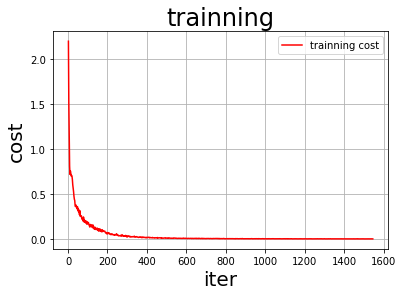

In [30]:
def draw_train_process(title, iters, costs, label_cost):
    plt.title(title, fontsize=24)
    plt.xlabel('iter', fontsize=20)
    plt.ylabel("cost", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    # plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()

draw_train_process('trainning', all_train_iters, all_train_costs,  'trainning cost')
# print('The lastest Accuracy rate is:', all_train_accs[-1])

至此往前继续做前面未完成的数据处理部分
## **模型预测**
>  模型位于 ./work/traffic.forecast.model  

进行模型预测 首先仍要进行数据处理


[[ 0.21364583 -0.12454788  0.00032905 ...  0.04138881  0.01917297
   0.03929274]
 [ 0.09051765  0.1508209   0.05951428 ...  0.00032905  0.01362859
   0.00727581]
 [ 0.08043586  0.00032905  0.00222377 ...  0.00445289  0.00032905
  -0.04617083]
 ...
 [ 0.00032905  0.00343483  0.00214619 ...  0.00354099  0.11074229
   0.08118554]
 [ 0.01173747  0.00379224  0.00284287 ... -0.01221224  0.02398797
  -0.00776665]
 [ 0.01080353  0.06151723  0.0056511  ... -0.00603919 -0.03411476
  -0.01438599]]
7.759214


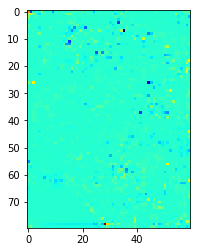

In [31]:
import numpy as np
from PIL import Image
import paddle.fluid as fluid
import matplotlib.pyplot as plt
import zipfile

test_zfile = zipfile.ZipFile("/home/aistudio/data/data1917/test_new.zip")
l_test = []
for test_fname in test_zfile.namelist()[1:]:
    l_test.append(test_fname)
    
test_img = Image.open(l_test[0])

plt.imshow(test_img)
test_img = test_img.resize((640,480))
test_im = np.array(test_img)
test_im = test_im / 255.0
test_im = test_im.transpose().reshape(1,3,640,480).astype('float32')

use = True
place1 = fluid.CUDAPlace(0) if use else fluid.CPUPlace()
# 定义一个executor
infer_exe = fluid.Executor(place1)

inference_scope = fluid.core.Scope()   #要想运行一个网络，需要指明它运行所在的域，确切的说： exe.Run(&scope) 。

model_save_dir = './work/traffic.forecast.model'

with fluid.scope_guard(inference_scope):
    #获取训练好的模型
    #从指定目录中加载 推理model(inference model)
    [inference_program,                           # 预测用的program
     feed_target_names,                           # 是一个str列表，它包含需要在推理 Program 中提供数据的变量的名称。 
     fetch_targets] = fluid.io.load_inference_model(model_save_dir, #fetch_targets：是一个 Variable 列表，从中我们可以得到推断结果。
                                                    infer_exe)      #infer_exe: 运行 inference model的 executor

    results = infer_exe.run(inference_program,                 #运行预测程序
                            feed={feed_target_names[0]: test_im},  #喂入要预测的img
                            fetch_list=fetch_targets)          #得到推测结果
    
    result = results[0][0][0]
    print(result)
    plt.imshow(result,cmap=CM.jet)
    
    print(np.sum(results[0]))

In [32]:
import numpy as np
from PIL import Image
import paddle.fluid as fluid
import matplotlib.pyplot as plt
import zipfile

# 这个东西虽然前面解压了 但是我还不知大根据文件目录遍历的方法
# 就用这个zipfile遍历了
test_zfile = zipfile.ZipFile("/home/aistudio/data/data1917/test_new.zip")
l_test = []
for test_fname in test_zfile.namelist()[1:]:
    # print(fname)
    l_test.append(test_fname)

use_cuda2 = True
place1 = fluid.CUDAPlace(0) if use_cuda2 else fluid.CPUPlace()
test_exe = fluid.Executor(place1)

test_scope = fluid.core.Scope()  

model_save_dir = '/home/aistudio/work/traffic.forecast.model'

data_dict = {}
with fluid.scope_guard(test_scope):
    [test_program, feed_target_names, fetch_targets] = fluid.io.load_inference_model(model_save_dir, test_exe)      

    for index in range(len(l_test)):
        test_img = Image.open(l_test[index])
        test_img = test_img.resize((640,480))
        test_im = np.array(test_img)
        test_im = test_im / 255.0
        test_im = test_im.transpose().reshape(1,3,640,480).astype('float32')
        l_test[index] = l_test[index].lstrip('test').lstrip('/')

        results = test_exe.run (    #运行预测程序
                                test_program,                
                                feed={feed_target_names[0]: test_im},  #喂入要预测的img
                                fetch_list=fetch_targets)          #得到推测结果
    
        people_num = np.sum(results)
        print(index, l_test[index], (people_num))
        data_dict[l_test[index]] = (people_num)
    
import csv

with open('results.csv', 'w') as csvfile:

    fieldnames = ['id', 'predicted']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for k, v in data_dict.items():

        writer.writerow({'id': k, 'predicted':v})